# Sea Lions Classification Model

Steps:

- Take 50x50 windows around sea lion dots
- Randomly take 50x50 windows around non sea lion regions (false cases)
- Train on 1-10 images
- Test on 1 image

In [2]:
import os
import glob
import math
import random
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage import io, img_as_float

from matplotlib import pyplot as plt
from collections import Counter


%matplotlib inline

Using TensorFlow backend.


In [59]:
WINDOW_SIZE = 30 # half size..

## Step 1: Load training data

In [60]:
# load paths
train_src = "../data/sealions"
train_imgs = sorted(glob.glob(os.path.join(train_src, "Train", "*.jpg")))
train_dots = sorted(glob.glob(os.path.join(train_src, "Dots", "*.csv")))

# training data
X = []
Y = []

def extract_window(row, img):
    s = WINDOW_SIZE
    x = row.width
    y = row.height
    window = img[x-s:x+s, y-s:y+s, :]
    if window.shape == (2*s, 2*s, 3):
        X.append(window)
        Y.append(row.sealion_type)

for i, j in zip(train_dots, train_imgs):
    df = pd.read_csv(i)
    im = img_as_float(io.imread(j))
    df.apply(extract_window, axis=1, args=(im,))

/usa/suryak/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [61]:
# Add false data (Can we do better?)
# Split image into windows; For every center of window, check whether there exists a sea lion nearby.
# If not, consider the window as false data. Followed by, take a subset of this sample space.
get_dist = lambda x, y: (x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2
min_dist = 200 # if this is low, there is a chance that the pixels in "true" and "false" samples get mixed up!
size = WINDOW_SIZE # this should be same as true data size..
false_X = []

for i, j in zip(train_dots, train_imgs):
    im = io.imread(j)
    df = pd.read_csv(i)
    for x1 in xrange(size, im.shape[0], 200):
        for y1 in xrange(size, im.shape[1], 200):
            for x2, y2 in df[["height", "width"]].values:
                if get_dist((x1,y1), (x2,y2)) > min_dist:
                    window = im[x1-size:x1+size, y1-size:y1+size, :]
                    if window.shape == (2*size, 2*size, 3):
                        false_X.append(window)

# take a random subset of 50% of true dataset size
random.seed(0)
subset = random.sample(false_X, int(len(X) * .8))

In [62]:
X.extend(subset)
Y.extend(["unknown"] * len(subset))

In [63]:
# convert labels to integers
enc = preprocessing.LabelBinarizer()
enc.fit(Y)
Y_enc = enc.transform(Y).astype(float)

# convert X to numpy array
X = np.array(X)

print X.shape
print enc.classes_

(2235, 60, 60, 3)
['adult_female' 'adult_male' 'juvenile' 'pup' 'sub_adult_male' 'unknown']


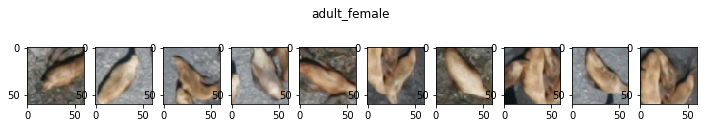

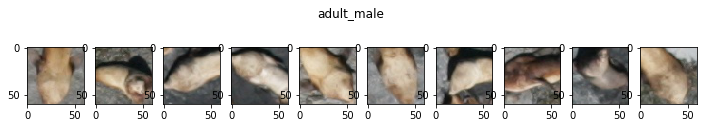

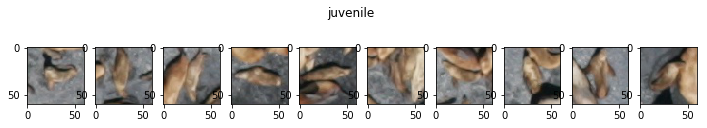

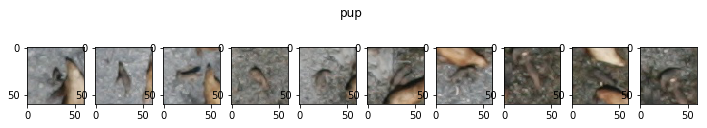

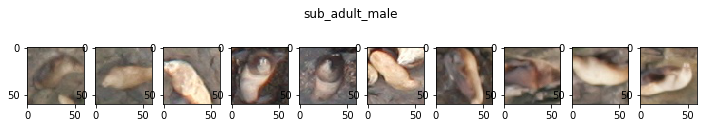

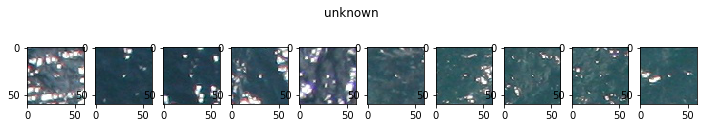

In [64]:
for cls in enc.classes_:
    lim = 10
    fig, ax = plt.subplots(1, lim, figsize=(12, 2))
    fig.suptitle(cls)
    ax = ax.flatten()
    for i in xrange(len(X)):
        if Y[i] == cls:
            lim -= 1
            ax[lim].imshow(X[i])
        if lim == 0:
            break

## Step 2: Train classifier

In [71]:
model = Sequential()

model.add(Lambda(lambda x: (x / 1.0) - 0.5, input_shape=X.shape[1:]))
model.add(Conv2D(30, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(60, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(120, (5, 5), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(480, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(enc.classes_), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X, Y_enc, validation_split=0.33, epochs=30, verbose=0)

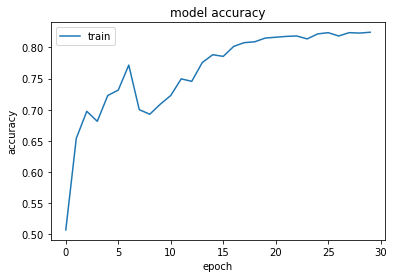

In [84]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Step 3: Count sea lions

In [79]:
# split image into windows
idx = 0
test_img = img_as_float(io.imread(train_imgs[idx]))
test_x = []
test_x_loc = []
s = 2*WINDOW_SIZE

for i in xrange(0, test_img.shape[0], s):
    for j in xrange(0, test_img.shape[1], s):
        window = test_img[i:i+s, j:j+s, :]
        if window.shape == X.shape[1:]:
            test_x.append(window)
            test_x_loc.append((i,j))

test_x = np.array(test_x)

In [81]:
test_y = model.predict(test_x)
test_y_labels = enc.inverse_transform(test_y)

In [82]:
filtered_y = []
filtered_idx = []
filtered_labels = []

for i, p in enumerate(test_y):
    if p[np.argmax(p)] > 0.9:
        filtered_y.append(p)
        filtered_idx.append(i)

filtered_y = np.array(filtered_y)
filtered_y_labels = enc.inverse_transform(filtered_y)
filtered_idx = np.array(filtered_idx)
Counter(filtered_y_labels)

Counter({'adult_female': 238,
         'adult_male': 54,
         'juvenile': 74,
         'pup': 892,
         'sub_adult_male': 55,
         'unknown': 264})

In [53]:
df = pd.read_csv(train_dots[idx])
df.groupby(["sealion_type"])["sealion_type"].count()

sealion_type
adult_female    85
adult_male      15
juvenile        18
pup             59
Name: sealion_type, dtype: int64

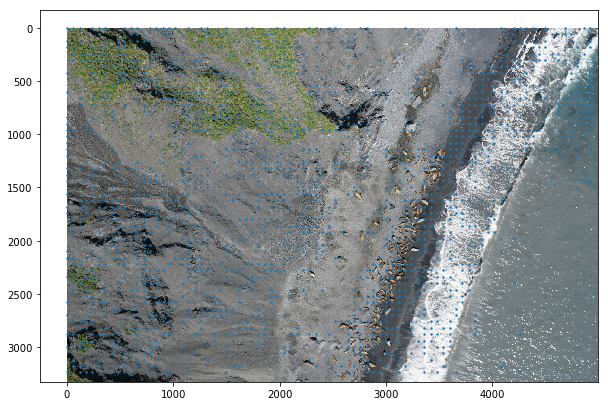

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(test_img)
ax.scatter(
    [test_x_loc[i][1] for i in filtered_idx],
    [test_x_loc[i][0] for i in filtered_idx],
    s=2
)

This is bad!! 